<a href="https://colab.research.google.com/github/durml91/MMath_Project/blob/main/Preliminary_SBM_investigation/DDPMs_spiral_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Very short DDPMs implementation for toy spiral example

#### Installs

In [1]:
!pip install equinox
!pip install einops

#### Imports

In [2]:
import jax
import jax.typing
import jax.numpy as jnp
import jax.random as jr
import einops
import typing
import equinox as eqx
import optax
import torch

In [3]:
import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(2023)

#### Random key generation

In [4]:
key = jr.PRNGKey(2022)

##### Data generation

**Get spiral**

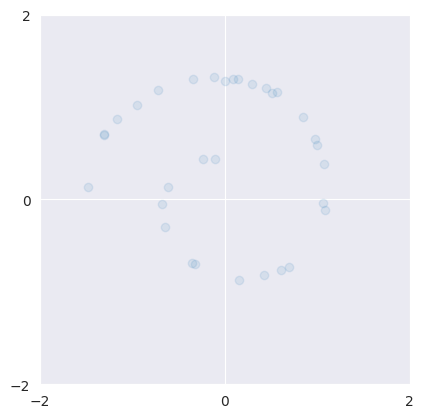

In [40]:
N = 32 #(or 1024)

def spiral(N):
  theta = np.sqrt(np.random.rand(N)) * 3 * np.pi  # we generate an array of shape (1024,) such that it they are uniform random numbers in [0,1) and then apply a bunch of operatrions on it
  r_a = 0.07 * (2 * theta + np.pi) #mutiply by trig function below by some constant r_a
  x = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T #here we produce two rows now of 1024 numbers that have been put through either function respectively - then tranpose so the shape ends up being (1024,2)

  x = x + 0.02 * np.random.randn(N, 2) #again we multiply by a bunch of uniform random numbers of the right broadcasting shape
  return x

data = spiral(N)

plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(data[:, 0], data[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

##### Forward direction and beta schedule

In [8]:
class DDPM():
  T: int
  beta_min: float
  beta_max: float

  def __init__(self, T, beta_min, beta_max):
    self.T = T
    self.beta_min = beta_min
    self.beta_max = beta_max

    self.beta_t = jnp.array([ (beta_min/T) + (i/(T*(T-1))) * (beta_max - beta_min) for i in range(T)])
    self.alpha = 1 - self.beta_t
    self.alpha_bar = jnp.cumprod(self.alpha)

  def forward_direction(self, x_0, t, key):
    epsilon = jr.normal(key, x_0.shape)
    sqrt_alpha_bar_t = jnp.take(jnp.sqrt(self.alpha_bar), t)
    one_minus_sqrt_alpha_bar_t = jnp.take(jnp.sqrt(1-self.alpha_bar), t)
    q_x_t = sqrt_alpha_bar_t * x_0 +  one_minus_sqrt_alpha_bar_t * epsilon
    return q_x_t, epsilon

  def reverse_direction(self, x_t, eps, t, key):
    alpha_t = jnp.take(self.alpha, t)
    alpha_t_bar = jnp.take(self.alpha_bar, t)

    coeff = (1 - alpha_t) / ((1 - alpha_t_bar) ** .5)

    mean = 1 / (alpha_t ** 0.5) * (x_t - coeff * eps)
    var = jnp.take(self.beta_t, t)

    z = jr.normal(key, x_t.shape)

    return mean + (var ** 0.5) * z

**Initialise DDPM class**

In [10]:
ddpm = DDPM(200, 0.1, 20)

**Visualise forward noising process**

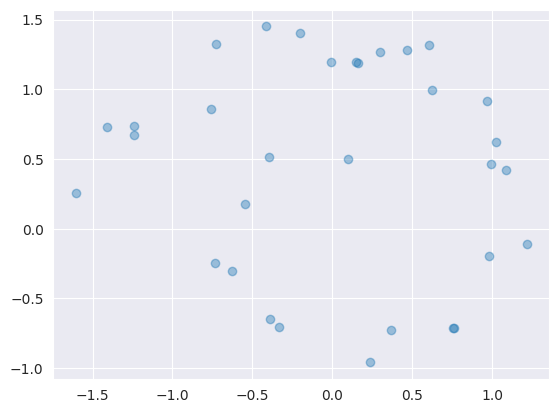

In [41]:
f_time = 5
q_x_t, _ = ddpm.forward_direction(data, jnp.array([f_time,]), key)
plt.scatter(q_x_t[:, 0], q_x_t[:, 1], alpha=0.4)

#### Training

**Set (hyper-)parameters/config**

In [31]:
T = ddpm.T
num_steps = 45_000
in_size = 2
dataset = data
batch_size = 1024
print_every = 5_000

**Neural Network**

In [18]:
class NN(eqx.Module):
  MLP: eqx.nn.MLP
  in_size: int
  out_size: int

  def __init__(self, in_size, key):
    self.in_size = in_size + 3
    self.out_size = in_size
    self.MLP = eqx.nn.MLP(self.in_size, self.out_size, 726, 6, jax.nn.gelu, key=key)

  def __call__(self, x, t):
    t = t[0]
    time = jnp.array([t/T, jnp.cos(2*jnp.pi*(t/T)), jnp.sin(2*jnp.pi*(t/T))])
    input = jnp.concatenate((x,time), axis = 0)
    return self.MLP(input)

**Loss functions and update step**

In [10]:
# def f_d(x_0, t, key):
#   noise = jr.normal(key, x_0.shape)
#   reshaped_sqrt_alpha_bar_t = jnp.take(sqrt_alpha_bar, t)
#   reshaped_one_minus_sqrt_alpha_bar_t = jnp.take(one_minus_sqrt_alpha_bar, t)
#   noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
#   return noisy_image, noise

In [26]:
@eqx.filter_value_and_grad
def compute_grads(
    model: eqx.Module,
    samples: jnp.array,
    key: jr.PRNGKey
):
  n = samples.shape[0]
  a_key, b_key = jr.split(key, 2)
  f_keys = jr.split(a_key, n)
  ts = jr.randint(b_key, shape = (n, 1), minval = 0.0, maxval = T)
  q_x_t, eps = jax.vmap(ddpm.forward_direction, in_axes=(0, 0, 0))(samples, ts, f_keys)
  eps_hat = jax.vmap(model, in_axes=(0, 0))(q_x_t, ts)
  return jnp.mean((eps - eps_hat) ** 2)

In [27]:
@eqx.filter_jit
def step_model(
    model: eqx.Module,
    optimizer: optax.GradientTransformation,
    state: optax.OptState,
    samples: jnp.array,
    key: jr.PRNGKey
):
  loss, grads = compute_grads(model, samples, key)
  updates, new_state = optimizer.update(grads, state, model)

  model = eqx.apply_updates(model, updates)

  (new_key, ) = jr.split(key, 1)

  return model, new_state, loss, new_key

**Set parameters and define dataloader**

In [42]:
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size = batch_size, shuffle=True, drop_last=True
)

In [29]:
def dataloader():
  while True:
    yield from train_loader

**Initialise model**

In [43]:
model = NN(in_size, key)

optimizer = optax.adam(
    learning_rate = 1e-3
)

state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

**Training loop**

In [44]:
for step, batch in zip(range(num_steps), dataloader()):
  samples = jnp.array(batch)

  model, state, loss, key = step_model(
      model, optimizer, state, samples, key
  )

  if (step%print_every) == 0 or step == num_steps - 1:
    print(f"Step: {step}/{num_steps}, Loss: {loss}")

Step: 0/45000, Loss: 0.9383586049079895
Step: 5000/45000, Loss: 0.17126281559467316
Step: 10000/45000, Loss: 0.17802950739860535
Step: 15000/45000, Loss: 0.1717502325773239
Step: 20000/45000, Loss: 0.20606565475463867
Step: 25000/45000, Loss: 0.1960161328315735
Step: 30000/45000, Loss: 0.18839667737483978
Step: 35000/45000, Loss: 0.1791960895061493
Step: 40000/45000, Loss: 0.17477789521217346
Step: 44999/45000, Loss: 0.20024454593658447


#### Sampling

**Compute the conditional probabilities over diffusion timeframe**

In [33]:
def sample(key):

  i_key, m_key = jr.split(key, 2)

  x = jr.normal(i_key, (2,))

  for i in range(0, T-1):
    r_t = T-i-1
    t = jnp.array([r_t, ]) # ((T-i)-1)
    eps = model(x, t)
    x = ddpm.reverse_direction(x, eps, t, m_key)
    (m_key, ) = jr.split(m_key, 1)

  return x

**Get samples and visualise**

In [37]:
n_samples = 500

In [45]:
s_key = jr.split(key, n_samples)
output = jax.vmap(sample, in_axes=(0))(s_key)

**When N=1024**

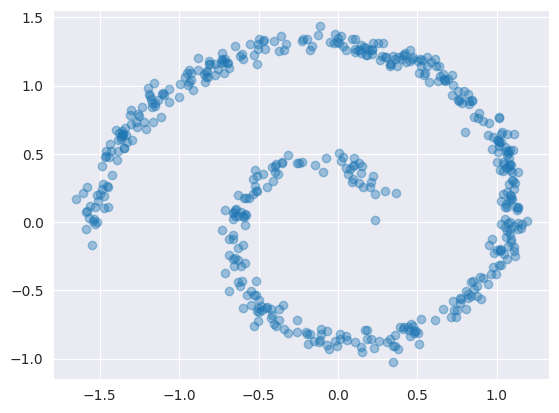

In [39]:
plt.scatter(output[:, 0], output[:, 1], alpha=0.4)

**When N=32**

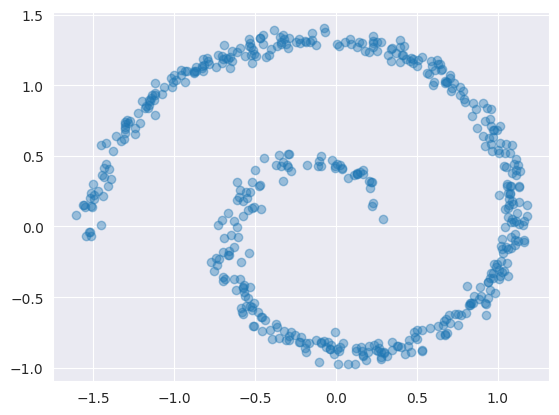

In [46]:
plt.scatter(output[:, 0], output[:, 1], alpha=0.4)